## Getting data from Strava

https://pythonhosted.org/stravalib/api.html#stravalib.client.Client.get_activity_streams

In [1]:
import settings
from stravalib.client import Client

client = Client(access_token = settings.STRAVA_ACCESS_TOKEN)

In [2]:
help(client.get_activities)

Help on method get_activities in module stravalib.client:

get_activities(before=None, after=None, limit=None) method of stravalib.client.Client instance
    Get activities for authenticated user sorted by newest first.
    
    http://strava.github.io/api/v3/activities/
    
    
    :param before: Result will start with activities whose start date is
                   before specified date. (UTC)
    :type before: datetime.datetime or str or None
    
    :param after: Result will start with activities whose start date is after
                  specified value. (UTC)
    :type after: datetime.datetime or str or None
    
    :param limit: How many maximum activities to return.
    :type limit: int or None
    
    :return: An iterator of :class:`stravalib.model.Activity` objects.
    :rtype: :class:`BatchedResultsIterator`



In [3]:
list(client.get_activities(after='2018-07-28', before='2018-07-29'))

[<Activity id=1733946479 name='Evening Ride' resource_state=2>,
 <Activity id=1732871895 name='22. Slapský triatlon - běh' resource_state=2>,
 <Activity id=1732801109 name='22. Slapský triatlon - kolo' resource_state=2>,
 <Activity id=1732407580 name='Morning Ride' resource_state=2>]

In [4]:
types = ['time', 'distance', 'latlng', 'altitude', 'velocity_smooth', 'moving', 'grade_smooth']
streams = client.get_activity_streams(1732801109, types=types)

## Visualizing elevation

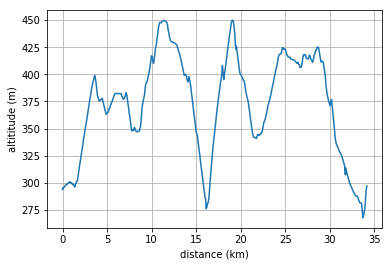

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.plot(streams['distance'].data, streams['altitude'].data)

ax.set(xlabel='distance (km)', ylabel='altititude (m)')
ax.grid()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000)))

plt.show()

### Group data to smoothen the visualization

In [6]:
locations = streams['latlng'].data
velocities = streams['velocity_smooth'].data

data = zip(locations, velocities)

groups = []

last_velocity = None
for location, velocity in data:
    if not last_velocity or abs(abs(last_velocity) - abs(velocity)) > 0.4:
        groups.append({'velocity': velocity, 'velocities': [], 'locations': []})
    groups[-1:][0]['locations'].append(location)
    groups[-1:][0]['velocities'].append(velocity)
    last_velocity = velocity

import statistics

for group in groups:
    group['velocity'] = statistics.median_high(group['velocities'])

### Folium

http://python-visualization.github.io/folium/quickstart.html

https://github.com/python-visualization/folium/blob/master/folium/plugins/heat_map.py

https://matplotlib.org/tutorials/colors/colormaps.html

To correctly colorize datapoints we need to normalize and map the values first. Luckily `matplotlib` does this for us.

In [7]:
import folium
from folium import plugins

m = folium.Map(location=[49.7947117,14.3916288], tiles='Stamen Toner', zoom_start=12.2)

def convert_to_hex(rgba_color):
    red = str(hex(int(rgba_color[0]*255)))[2:].capitalize()
    green = str(hex(int(rgba_color[1]*255)))[2:].capitalize()
    blue = str(hex(int(rgba_color[2]*255)))[2:].capitalize()

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue
    
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.bwr
norm = Normalize(vmin=min(velocities), vmax=max(velocities))

def colorize(grade):
    return convert_to_hex(cmap(norm(grade)))

for group in groups:
    folium.PolyLine(
        group['locations'],
        weight=10,
        color=colorize(group['velocity'])
    ).add_to(m)

m

In [ ]:
m.save('index.html')